# Using MIOFlow to discover cell trajectories in Embryoid Body Data

Goals:
- Preprocess data to be used on downstream investigation

## Installation

```bash
pip install mioflow
```

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import phate

## [Optional] Downloading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
download_path
└── scRNAseq
    ├── scRNAseq.zip
    ├── T0_1A
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T2_3B
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T4_5C
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T6_7D
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    └── T8_9E
        ├── barcodes.tsv
        ├── genes.tsv
        └── matrix.mtx
```

If you have downloaded the files already, set the `download_path` below to the directory where you saved the files. If not, the following code will download the data for you. Not that the download is 746MB: you must have sufficient disk space for the download.

In [24]:
import os
import urllib.request
import zipfile
import shutil

def download_and_extract_scrna(download_path ="data/scRNAseq"):
    # Set up the download path
    os.makedirs(download_path, exist_ok=True)
    
    # Download URL
    url = "https://data.mendeley.com/public-api/zip/v6n743h5ng/download/1"
    zip_file = os.path.join(download_path, "v6n743h5ng-1.zip")
    
    print(f"Downloading from {url}...")
    req = urllib.request.Request(url, headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
    })
    with urllib.request.urlopen(req) as response, open(zip_file, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    # urllib.request.urlretrieve(url, zip_file)

    print(f"Downloaded to {zip_file}")
    
    # Extract the outer zip file to a temp directory
    temp_extract = os.path.join(download_path, "temp_extract")
    os.makedirs(temp_extract, exist_ok=True)
    
    print("Extracting outer zip file...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(temp_extract)
    
    # Find and extract the scRNAseq.zip file
    scrna_zip = os.path.join(temp_extract, "scRNAseq.zip")
    if os.path.exists(scrna_zip):
        print("Extracting scRNAseq.zip...")
        with zipfile.ZipFile(scrna_zip, 'r') as zip_ref:
            zip_ref.extractall(temp_extract)
    
    # Move contents of scRNAseq folder to the main directory
    scrna_folder = os.path.join(temp_extract, "scRNAseq")
    if os.path.exists(scrna_folder):
        print("Moving scRNAseq contents to main directory...")
        for item in os.listdir(scrna_folder):
            src = os.path.join(scrna_folder, item)
            dst = os.path.join(download_path, item)
            shutil.move(src, dst)
            print(f"  Moved: {item}")
    
    # Clean up temp directory and zip file
    shutil.rmtree(temp_extract)
    os.remove(zip_file)
    print("Cleaned up temporary files")
    
    print(f"\nDone! scRNAseq data is in: {download_path}")
    print("\nFinal contents:")
    for item in os.listdir(download_path):
        print(f"  - {item}")

    return download_path
# Run the function
data_path = download_and_extract_scrna(download_path='data/scRNAseq')

Downloaded to data/scRNAseq/v6n743h5ng-1.zip
Extracting outer zip file...
Extracting scRNAseq.zip...
Moving scRNAseq contents to main directory...
  Moved: T6_7D
  Moved: T8_9E
  Moved: T4_5C
  Moved: T2_3B
  Moved: T0_1A
Cleaned up temporary files

Done! scRNAseq data is in: data/scRNAseq

Final contents:
  - T6_7D
  - T8_9E
  - T4_5C
  - T2_3B
  - T0_1A


In [25]:
samples = ['T0_1A', 'T2_3B', 'T4_5C', 'T6_7D', 'T8_9E']
labels = ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']

adatas = []
for sample, label in zip(samples, labels):
    adata = sc.read_10x_mtx(os.path.join(data_path, sample), var_names='gene_symbols', make_unique=True,cache=True)
    adata.obs['timepoint'] = label
    adatas.append(adata)

# Concatenate all samples
adata = sc.concat(adatas, merge="same")
adata.obs_names_make_unique()
print(f"Loaded {adata.n_obs} cells and {adata.n_vars} genes")

Loaded 31161 cells and 33694 genes


/Users/joaofelipe/miniconda3/envs/omics-toolbox/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# 1. Data Preprocessing

### Quality control metrics
Quality Control from scanpy's [documentation](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html):

_The scanpy function calculate_qc_metrics() calculates common quality control (QC) metrics, which are largely based on calculateQCMetrics from scater [McCarthy et al., 2017]. One can pass specific gene population to calculate_qc_metrics() in order to calculate proportions of counts for these populations._

In [26]:
# Calculate QC metrics
## Here we are also computing quality control specific for Mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

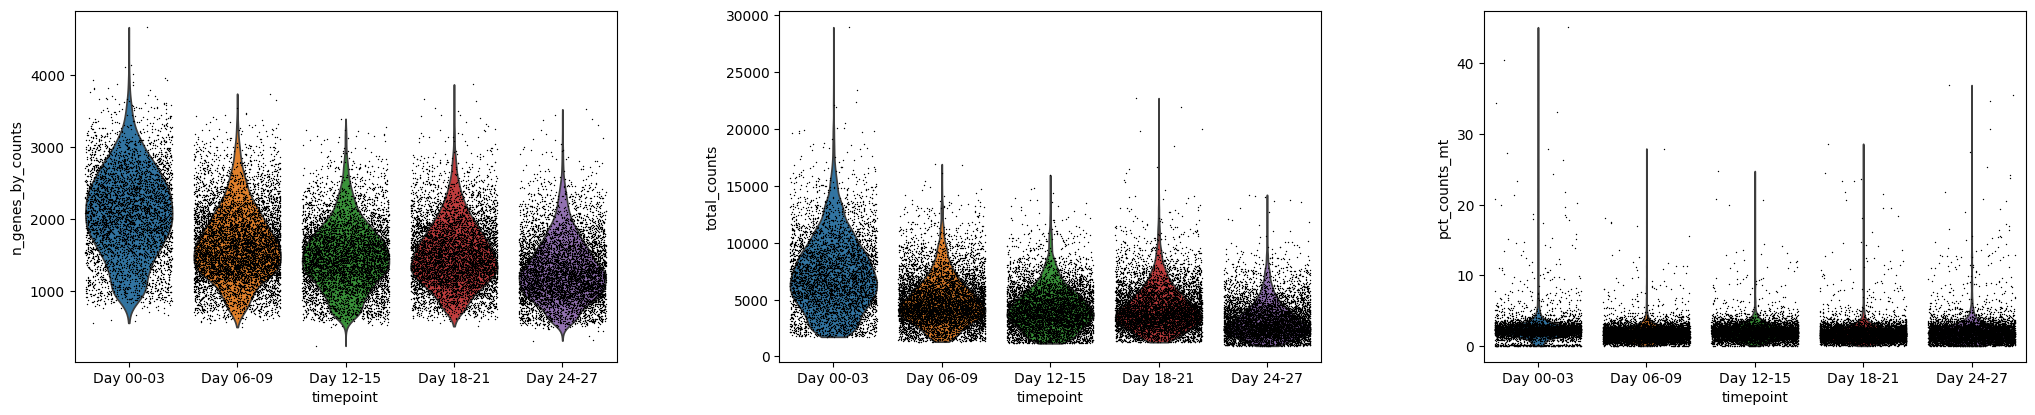

In [27]:
# Visualize QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='timepoint')

### Library Size Filtering
We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample (see the violin plots above) and so we filter on a per-sample basis. 

In this case, we eliminate the top and bottom 20% of cells for each sample. Similar results are obtained with simpler, less conservative filtering.

First, let's plot to observe the distribution

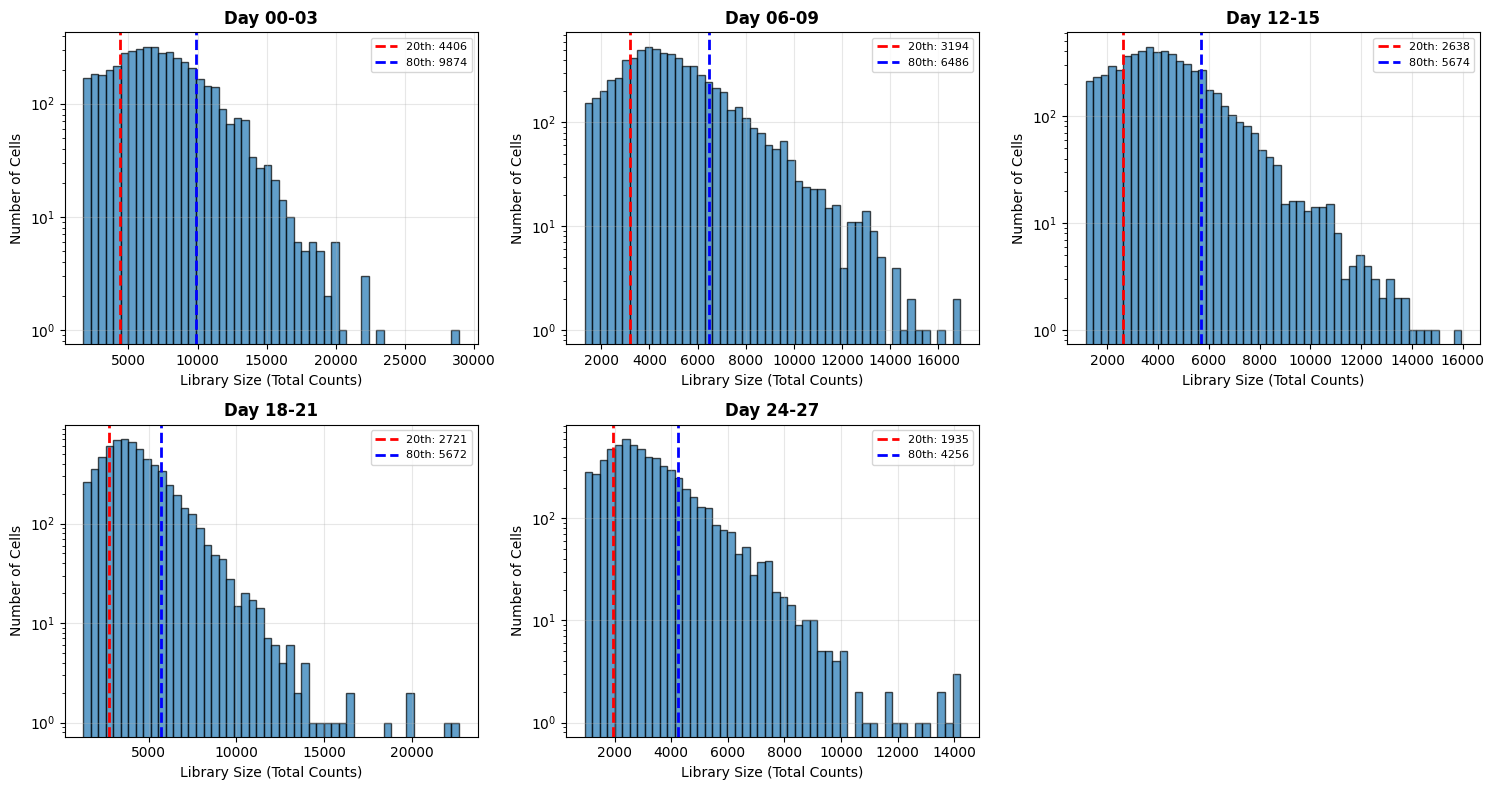

In [28]:
#Let's set a percentile to filter
min_percentile = 20 # Filter cells lower than the 20th percentile
max_percentile = 80 # Filter cells higher than the 80th percentile

# Create a plot for each sample
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (sample, label) in enumerate(zip(samples, labels)):
    # Filter data for this sample
    sample_mask = adata.obs['timepoint'] == label
    sample_counts = adata.obs.loc[sample_mask, 'total_counts']
    
    # Calculate thresholds for this sample
    threshold_min = np.percentile(sample_counts, min_percentile)
    threshold_max = np.percentile(sample_counts, max_percentile)
    
    # Plot
    axes[idx].hist(sample_counts, bins=50, alpha=0.7, edgecolor='black', log=True)
    axes[idx].axvline(threshold_min, color='red', linestyle='--', linewidth=2,
               label=f'{min_percentile}th: {threshold_min:.0f}')
    axes[idx].axvline(threshold_max, color='blue', linestyle='--', linewidth=2,
               label=f'{max_percentile}th: {threshold_max:.0f}')
    axes[idx].set_xlabel('Library Size (Total Counts)', fontsize=10)
    axes[idx].set_ylabel('Number of Cells', fontsize=10)
    axes[idx].set_title(f'{label}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Filter cells per sample based on library size percentiles
cells_to_keep = []

for sample, label in zip(samples, labels):
    # Get cells for this sample
    sample_mask = adata.obs['timepoint'] == label
    sample_counts = adata.obs.loc[sample_mask, 'total_counts']
    
    # Calculate thresholds for this sample
    threshold_min = np.percentile(sample_counts, min_percentile)
    threshold_max = np.percentile(sample_counts, max_percentile)
    
    # Identify cells to keep for this sample
    keep_mask = (sample_counts >= threshold_min) & (sample_counts <= threshold_max)
    cells_to_keep.extend(sample_counts[keep_mask].index.tolist())
    
    print(f"{label}: keeping {keep_mask.sum()}/{len(sample_counts)} cells "
          f"(range: {threshold_min:.0f} - {threshold_max:.0f})")
    
# Filter the AnnData object
adata = adata[cells_to_keep, :].copy()
print(f"\nTotal cells after filtering: {adata.n_obs}")

Day 00-03: keeping 2789/4649 cells (range: 4406 - 9874)
Day 06-09: keeping 4425/7377 cells (range: 3194 - 6486)
Day 12-15: keeping 3747/6245 cells (range: 2638 - 5674)
Day 18-21: keeping 3939/6563 cells (range: 2721 - 5672)
Day 24-27: keeping 3796/6327 cells (range: 1935 - 4256)

Total cells after filtering: 18696


### Removing rare genes
Let's eliminate genes that are expressed in 10 cells or fewer.

In [30]:
# Eliminate genes that are expressed in few cells
min_cells = 10
sc.pp.filter_genes(adata, min_cells=min_cells)

### Normalization
To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In [31]:
# Normalize to median library size
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs['total_counts']))

### Dead cell removal
Dead cells are likely to have a higher mitochondrial RNA expression level than live cells. Therefore, we remove suspected dead cells by eliminating cells that have the highest mitochondrial RNA expression levels on average.  

First let's look at the distribution of mitochontrial genes.

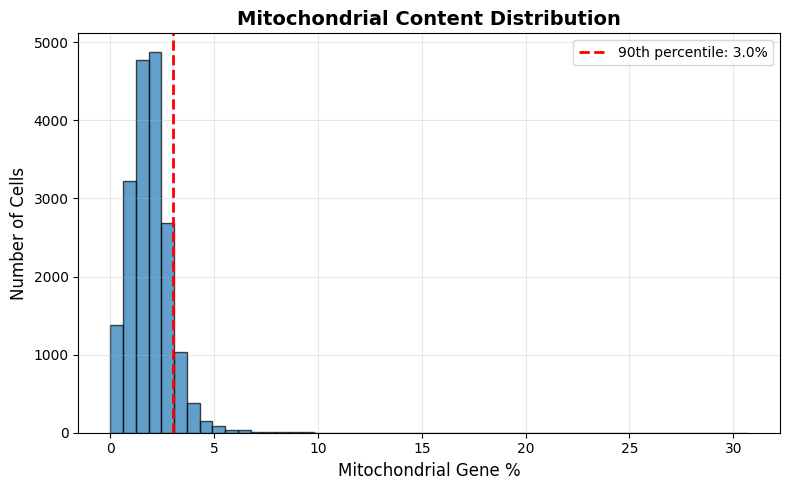

In [32]:
# Get mitochondrial percentages
mito_pct = adata.obs['pct_counts_mt']
mito_percentile = 90
mito_threshold = np.percentile(mito_pct, mito_percentile)  # Upper percentile

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(mito_pct, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(mito_threshold, color='red', linestyle='--', linewidth=2,
           label=f'{mito_percentile}th percentile: {mito_threshold:.1f}%')
ax.set_xlabel('Mitochondrial Gene %', fontsize=12)
ax.set_ylabel('Number of Cells', fontsize=12)
ax.set_title('Mitochondrial Content Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Filter cells with high mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < mito_threshold].copy()

### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [34]:
# Square root transform (alternative to log transform, stable at zero)
# sc.pp.log1p(adata)  # You can also use log1p if preferred
adata.X = np.sqrt(adata.X) # We use 

# 2. Dimensionality Reduction

### Embedding Data Using PCA and PHATE

Here we need to embed our data into a lower dimentional space.

This allows us to compute distances on PCA space and regularize by PHATE.

For this we simply compute PCA from scanpy.

In [35]:
n_components = 50
#This function will change adata inplace and add X_pca into adata.obsm
pca_df = sc.pp.pca(adata, n_comps=n_components)

In [36]:
adata

AnnData object with n_obs × n_vars = 16826 × 17845
    obs: 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'timepoint_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


### 2.2. Embedding Data Using PHATE

We are going to run PHATE over the lower dimensional PCA space.

#### 2.2.1 Instantiating the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE:

In [37]:
phate_operator = phate.PHATE(n_jobs=-2,n_components=2)

X_phate = phate_operator.fit_transform(adata.obsm['X_pca'])

# Here we add the X_phate to adata
# X_phate is the embedding of the data and can also be used for visualization

adata.obsm['X_phate'] = X_phate


Calculating PHATE...
  Running PHATE on 16826 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 3.85 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 3.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.43 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.53 seconds.
  Calculated landmark operator in 2.34 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.93 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.36 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.90 seconds.
Calculated PHATE in 9.44 seconds.


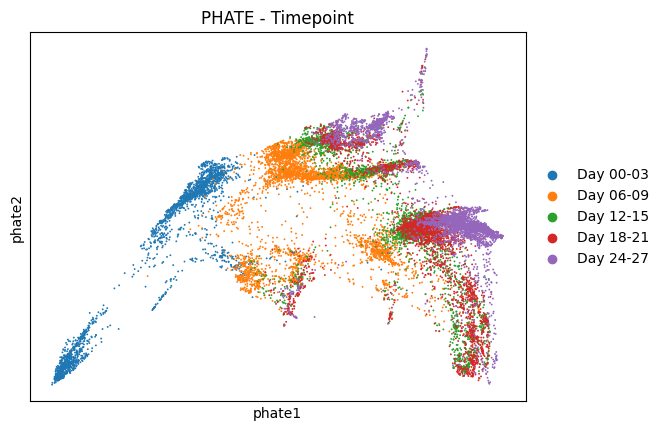

In [38]:
# Visualize PHATE colored by timepoint
sc.pl.embedding(adata, basis='phate', color='timepoint', cmap="Spectral",title='PHATE - Timepoint')

# 2. Choosing a feature to find trajectories

We want our trajectories to follow some dynamics that we want to discover trends about.
Let's start by looking at our PHATE space. This is the latent space we want to find trajectories in.

Now, we need to choose a feature to "guide" our space. Let's check the avalable features:

In [39]:
adata.obs

,timepoint,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCGTGCAGAAA-1,Day 00-03,1581,4602.0,125.0,2.716210
AAACGCACCGGTAT-1,Day 00-03,2550,9558.0,252.0,2.636535
AAACGCACCTATTC-1,Day 00-03,2316,8084.0,224.0,2.770905
AAAGATCTCTGCTC-1,Day 00-03,1848,5463.0,132.0,2.416255
AAAGATCTGGTACT-1,Day 00-03,2350,8797.0,214.0,2.432647
...,...,...,...,...,...
TTTCGAACTTCTCA-1,Day 24-27,1132,2582.0,34.0,1.316809
TTTCTACTCTTATC-1,Day 24-27,1115,2453.0,47.0,1.916021
TTTCTACTTGAGCT-1,Day 24-27,1031,2330.0,16.0,0.686695
TTTGCATGATGACC-1,Day 24-27,927,2005.0,55.0,2.743142


In our case, we know we want to get trajectories over the time samples of our collected data.

We want trajectories that go from the initial sample all the way to the final time point, while following the data structure (manifold)

So we will use the 'time_label'.

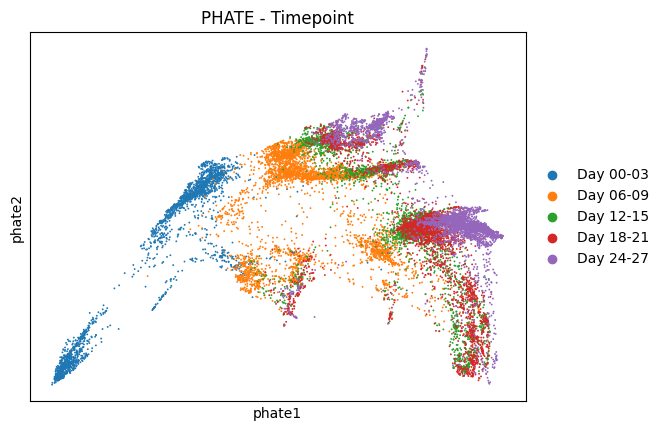

In [40]:
# Visualize PHATE colored by timepoint
sc.pl.embedding(adata, basis='phate', color='timepoint', cmap="Spectral",title='PHATE - Timepoint')

# 3. Preparing the data to MIOFlow

The MIOFlow algorithm expects data in a standart format, so we cannot simply send our adata directly to the algorithm.
The algorithm expects discreate timelabels to flow.

We just need to create the time_bin column.


In [41]:
# Create a numerical bin for each timepoint
print("Creating time_bin from timepoints...")
adata.obs['time_bin'] = adata.obs['timepoint'].map({
    'Day 00-03': 0.,
    'Day 06-09': 1.,
    'Day 12-15': 2.,
    'Day 18-21': 3.,
    'Day 24-27': 4.,
})
adata.obs[['timepoint', 'time_bin']].head()

Creating time_bin from timepoints...


,timepoint,time_bin
AAACCGTGCAGAAA-1,Day 00-03,0.0
AAACGCACCGGTAT-1,Day 00-03,0.0
AAACGCACCTATTC-1,Day 00-03,0.0
AAAGATCTCTGCTC-1,Day 00-03,0.0
AAAGATCTGGTACT-1,Day 00-03,0.0


Perfect! We have the necessary input for MIOFlow. Let's do a final check that this data contains everything we want to infer on top.

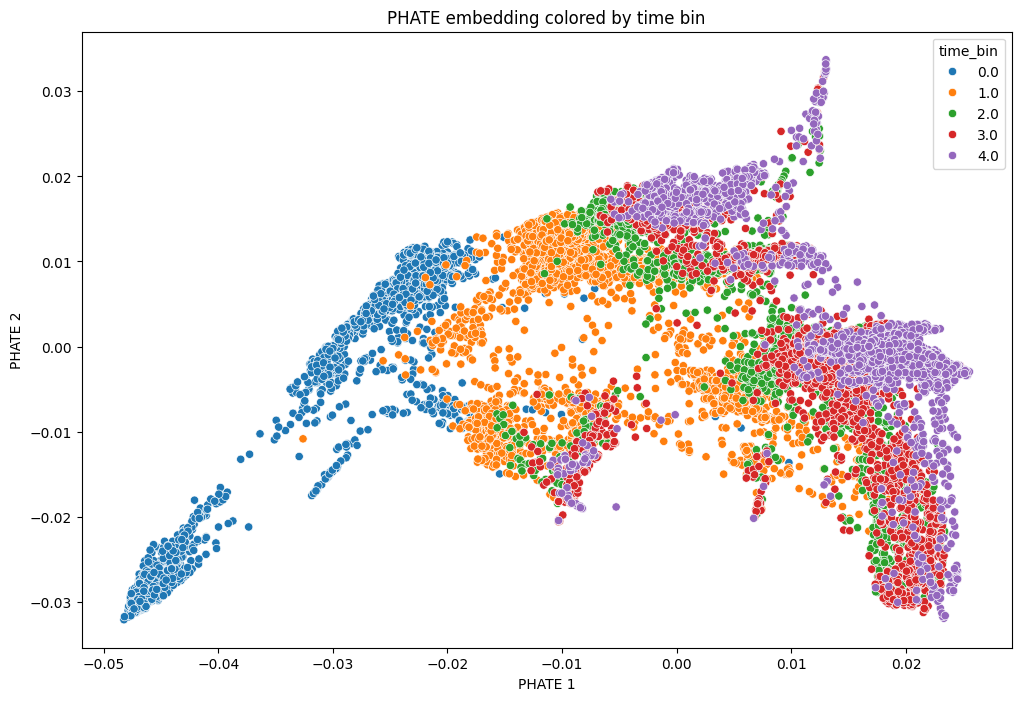

In [42]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=adata.obsm['X_phate'][:, 0],
    y=adata.obsm['X_phate'][:, 1],
    hue=adata.obs['time_bin'],
    palette='tab10'
)
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE embedding colored by time bin')
plt.show()

If your data looks right, and we can see a path for the trajectories to follow, we can move on to training the MIOFlow algorithm.

# 4. Saving the preprocessed data

Save the fully preprocessed `AnnData` object so it can be loaded directly in downstream notebooks without repeating all preprocessing steps.

In [43]:
save_path = os.path.join(data_path, 'preprocessed_eb_adata.h5ad')
adata.write_h5ad(save_path)
print(f"Saved preprocessed AnnData to: {save_path}")
print(adata)

Saved preprocessed AnnData to: data/scRNAseq/preprocessed_eb_adata.h5ad
AnnData object with n_obs × n_vars = 16826 × 17845
    obs: 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'time_bin'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'timepoint_colors', 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
